In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#box length for periodic boundary condition
#Temperature for sampling velocity
#Time step for simulation
#Number of steps
#ephsilon for A-B,A-A, and B-B interaction
#sigma for A-B,A-A, and B-B interaction
#cutoff for interaction r=rc*sigma
boxLength=4.3679
T=2
dt=0.003
nSteps=1000
mass=1
εAA = 1.0 
εAB = 1.5
εBB = 0.5
σAA = 1.0
σAB = 0.8
σBB = 0.88
rc = 2.5


In [3]:
#Loading the position and type of atoms
position=np.load("LJ_A80B20_3D_100_pos.npy")
typeSpecies=np.load("LJ_A80B20_3D_100_species.npy")
typeSpecies=np.where(typeSpecies==0,-1.0,1.0)
position=position%boxLength

In [4]:
N=position.shape[0]
d=position.shape[1]

In [5]:
#pairwise lj potential given the distance between the,
def ljp(r, epsilon=1, sigma=1):
    return  (4*epsilon*((sigma/r)**12-(sigma/r)**6))

In [6]:
#pairwise force between the two particles
def ljForce(r,epsilon=1, sigma=1):
    return 48 * epsilon * np.power(sigma / r, 13) - 24 * epsilon * np.power(sigma / r, 7)

Text(0, 0.5, 'Potential')

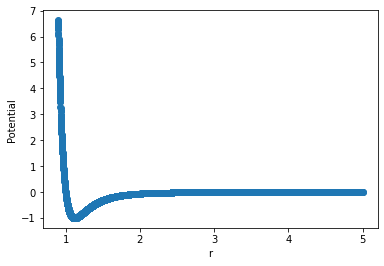

In [23]:
#plotting the LJ potential 
X = np.random.uniform(0.9,5, 10000).reshape(-1,1)
Y = ljp(X,1, 1)
Z = ljForce(X,1,1)
plt.scatter(X,Y)
plt.xlabel("r")
plt.ylabel("Potential")

Text(0, 0.5, 'Force')

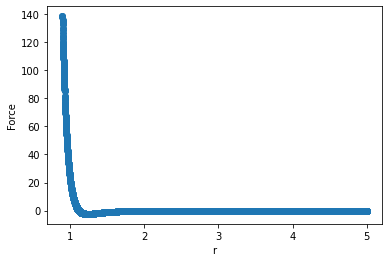

In [24]:
#plotting the Lforce 
plt.scatter(X,Z)
plt.xlabel("r")
plt.ylabel("Force")

In [9]:
#total lj potential for the system
def totalPE(position):
    position=position.reshape(N,d)
    position=(position+boxLength)%boxLength
    PE=0
    cutoff=0
    for i in range(len(position)):
        for j in range(i+1,len(position)):
            #periodic boundary condition
            r=np.abs(position[i]-position[j])%boxLength
            r=np.where(r>boxLength/2,boxLength-r,r)
            
            dr=np.linalg.norm(r)
            typeInteraction=typeSpecies[i]+typeSpecies[j]
            cutoff=np.where(typeInteraction==0, rc*σAB ,np.where(typeInteraction<0, rc*σAA, rc*σBB))
            PE+=np.where(dr>cutoff,0.0, np.where(typeInteraction==0, ljp(dr,εAB,σAB),np.where(typeInteraction<0, ljp(dr,εAA,σAA), ljp(dr,εBB,σBB))) )
    return PE

In [10]:
print("The total potential energy of the system is given by ", totalPE(position))

The total potential energy of the system is given by  -792.9939374989526


In [11]:
#assigning the velocity from a random distribution with a given temperature
def assignVelocity(T=T):
    mean=0
    var=np.sqrt(T)
    return np.random.normal(mean,var,size=(N,d))

In [12]:
#calculating the total Kinetic energy
def totalKE(velocity):
    return np.sum(mass*(np.linalg.norm(velocity,axis=1))**2)/2
    

In [13]:
#get the acceleration of the system given the position
def getAcceleration(position):
    position=position%boxLength
    acceleration=np.zeros((N,d))
    
    for i in range(N):
        for j in range(i+1,N):
            #periodic boundary finding the shifted/new displacement vector
            rabs=np.abs(position[j]-position[i])
            rsign=np.sign(position[j]-position[i])
            
            r=np.where(rabs>boxLength/2,-1*rsign*(boxLength-rabs),rsign*rabs)
            
            dr=np.linalg.norm(r)            
            typeInteraction=typeSpecies[i]+typeSpecies[j]
            cutoff=np.where(typeInteraction==0, rc*σAB ,np.where(typeInteraction<0, rc*σAA, rc*σBB))
            
            if dr>cutoff:
                continue
    
            forceMagnitude=np.where(typeInteraction==0, ljForce(dr,εAB,σAB),np.where(typeInteraction<0, ljForce(dr,εAA,σAA), ljForce(dr,εBB,σBB)))
            force=(forceMagnitude*r)/dr
            
            acceleration[i]-=force/mass
            acceleration[j]+=force/mass
    return acceleration

In [14]:
#updating the position of the particles using velocity verlet
def getPosition(position,velocity,acceleration):
    position += velocity * dt + 0.5 * acceleration * dt * dt
    return position%boxLength

In [15]:
#updating the velocity of the particles using velocity-verlet 
def getVelocity(v,a,a1):
    return v + 0.5 * (a + a1) * dt

In [16]:
#run MD simulation given the initial position and number of steps to run
def runMDSimulation(position,nSteps=nSteps):
    PE=[]
    KE=[]
    trajectory=[]
    velocity=assignVelocity(T=T)
    acceleration=getAcceleration(position)
    
    PE.append(totalPE(position))
    KE.append(totalKE(velocity))
    trajectory.append(position)
    
    for i in range(nSteps):
        print("Running simulation step ", str(i))
        
        position=position%boxLength
        updatedPosition=getPosition(position,velocity,acceleration)
        updatedPosition=updatedPosition%boxLength
        updatedAcceleration=getAcceleration(updatedPosition)
        velocity=getVelocity(velocity,acceleration,updatedAcceleration)
        
        position=updatedPosition
        acceleration=updatedAcceleration

        PE.append(totalPE(position))
        KE.append(totalKE(velocity))
        trajectory.append(position)

    return np.array(trajectory),np.array(PE),np.array(KE)

In [17]:
nSteps=nSteps
trajectory,PE,KE=runMDSimulation(position,nSteps=nSteps)
TE=PE+KE

Running simulation step  0
Running simulation step  1
Running simulation step  2
Running simulation step  3
Running simulation step  4
Running simulation step  5
Running simulation step  6
Running simulation step  7
Running simulation step  8
Running simulation step  9
Running simulation step  10
Running simulation step  11
Running simulation step  12
Running simulation step  13
Running simulation step  14
Running simulation step  15
Running simulation step  16
Running simulation step  17
Running simulation step  18
Running simulation step  19
Running simulation step  20
Running simulation step  21
Running simulation step  22
Running simulation step  23
Running simulation step  24
Running simulation step  25
Running simulation step  26
Running simulation step  27
Running simulation step  28
Running simulation step  29
Running simulation step  30
Running simulation step  31
Running simulation step  32
Running simulation step  33
Running simulation step  34
Running simulation step  35
Ru

In [18]:
#saving the trajectory
np.save("trajectory.npy",trajectory)

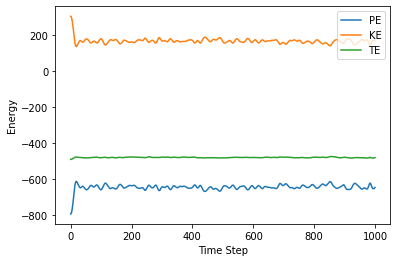

In [34]:
#plotting PE,KE and total energy
plt.plot(PE,label="PE")
plt.plot(KE,label="KE")
plt.plot(TE,label="TE")
plt.xlabel("Time Step")
plt.ylabel("Energy")
plt.legend(loc="upper right")


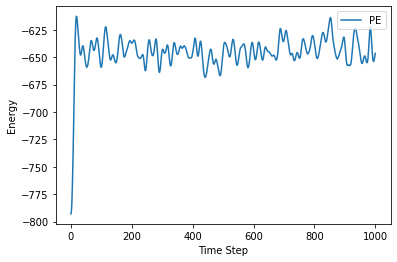

In [35]:
plt.plot(PE,label="PE")
plt.xlabel("Time Step")
plt.ylabel("Energy")
plt.legend(loc="upper right")

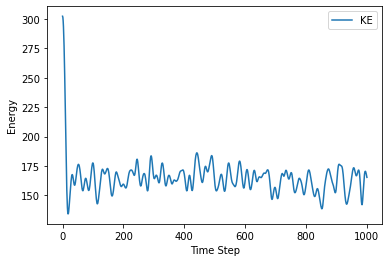

In [36]:
plt.plot(KE,label="KE")
plt.xlabel("Time Step")
plt.ylabel("Energy")
plt.legend(loc="upper right")

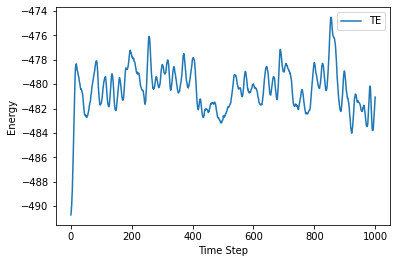

In [37]:
plt.plot(TE,label="TE")
plt.xlabel("Time Step")
plt.ylabel("Energy")
plt.legend(loc="upper right")